## Number of events

In [1]:
import numpy as np
import scipy as sc
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from scipy import stats
from scipy import signal
import xarray as xr

In [2]:
def theta1_cal( pc1, pc2 ):
    theta1           =  np.zeros(pc2.size)
    angle180         =  np.arctan2(-pc2, -pc1) * 180 / np.pi
    indNeg           =  np.where(angle180<0)[0]
    angle360         = angle180
    angle360[indNeg] = angle180[indNeg] + 360
    theta1           = np.around( ( angle360 + 22.5 ) * 8 / 360 )
    return theta1

def seas_separate(theta1_rmm,amp1_rmm,s_year,e_year):
    ph1=theta1_rmm.loc[str(s_year)+'-11-01':str(e_year)+'-04-30']*1
    a1=amp1_rmm.loc[str(s_year)+'-11-01':str(e_year)+'-04-30']*1
    return ph1,a1


def phase_freq_cal(theta1_rmm,amp1_rmm,threshold,s_year,n):
    t123 = np.zeros((n,))
    t567 = np.zeros((n,))
    t78 =np.zeros((n,))
    n1   = s_year
    
    for i in np.arange(n):
        a=[];p=[];
        p,a  = seas_separate(theta1_rmm,amp1_rmm,n1,n1+1)
        k    = np.where(a<threshold)[0]
        p[k] = 0  
        t123[i] = np.size(np.where(p==1)[0])+np.size(np.where(p==2)[0])+np.size(np.where(p==3)[0])
        t567[i] = np.size(np.where(p==4)[0])+np.size(np.where(p==5)[0])+np.size(np.where(p==6)[0])
        t78[i] = np.size(np.where(p==7)[0])+np.size(np.where(p==8)[0])

        n1 = n1+1
        
    return t123,t567,t78

def tot_phase(theta1_rmm,amp1_rmm,threshold,s_year,n):
    tt = np.zeros((n,))
    n1   = s_year
    for i in np.arange(n):
        a=[];p=[];
        p,a  = seas_separate(theta1_rmm,amp1_rmm,n1,n1+1)
        k    = np.where(a<threshold)[0]
        p[k] = 0  
        tt[i] = len(np.where(p!=0)[0])
        n1= n1+1
    return tt


def lowpass_scipy(signal,sample_freq,time_period,keep_mean):
    import numpy as np
    import scipy as sc
    from scipy import fftpack
    
    lowpass_signal=np.zeros(signal.shape)
    if any(np.isnan(signal)):
        raise ValueError('There is NaN in the signal')
    else:
        hf = 1./time_period

        temp_fft = sc.fftpack.fft(signal)

        fftfreq = np.fft.fftfreq(len(signal),sample_freq) ### daily data it is 1./365 ## monthly data 1./12 ## yearly data=1
          
        i1 = np.abs(fftfreq) >= hf  
        
        temp_fft[i1] = 0
        if not(keep_mean):
            temp_fft[0]=0
        lowpass_signal= np.real_if_close(sc.fftpack.ifft(temp_fft))
    
    return lowpass_signal

def lowpass_scipy_butter(signal1,wn,lt):
    from scipy import signal
    w = 2/lt # Normalize the frequency
    b, a = signal.butter(wn, w, 'low')
    lowpass_signal = signal.filtfilt(b, a, signal1)

    return lowpass_signal


def smooth(x,window_len=11,window='hanning'):
    ##https://scipy-cookbook.readthedocs.io/items/SignalSmooth.html
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.
    output:
        the smoothed signal
        
    example:
    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

In [3]:
def select_seg1_modf(i,len_1,len_0):
    
    ind1 = []
    ind2 = []
    z = []
    i[0] = 0
    i[-1] = 0
    t2 = i[1:]
    t3 = i[0:-1];
    z =  t2-t3;
   
    ind1 = np.where(z == 1)[0] +1;
    ind2 = np.where(z == -1 ) [0]+1 ;
    
    if (ind1[0] > ind2[0]):
        ind2 = ind2[1:]
    if (ind1[-1]>ind2[-1]):
        ind1 = ind1[:-1]
    
#     print(len(ind1))
    
    ind_1 = np.where((ind2-ind1)< len_1)[0]
    
#     print(len(ind_1))
    
    ind1 = np.delete(ind1,ind_1)
    ind2 = np.delete(ind2,ind_1)
    k = ind1[1:] - ind2[:-1]
    w = np.where(k<=len_0)[0]
    
    while len(w)>0:
        for j in w:
                ind2[j] = ind2[j+1]
        ind1 = np.delete(ind1,j+1)
        ind2 = np.delete(ind2,j+1)
        k = ind1[1:] - ind2[:-1]
        w = np.where(k<=len_0)[0]
     
   
    return ind1,ind2


def mjo_events(AA,PP,s_year,n,opt):
    
    len_1 =  15
    len_0 =  8
    sphase = 5
    ephase = 6
    ph_cov = 6
    ph = np.array([1,2,3,4,5,6,7,8])
    
    no_events  = np.zeros((n,))
    life_span  = np.zeros((n,))
    lf_567 = np.zeros((n,))
    lf_123 =np.zeros((n,))
    
    events = np.zeros((n,), dtype=np.object)
    
    n1   = s_year
    
    for i in np.arange(n):

        if opt=='allyear':
            a1 = AA.loc[str(n1)+'-01-01':str(n1)+'-12-31'].values*1
            p1 = PP.loc[str(n1)+'-01-01':str(n1)+'-12-31'].values*1
        elif opt=='summer':
            a1 = AA.loc[str(n1)+'-05-01':str(n1)+'-10-31'].values*1
            p1 = PP.loc[str(n1)+'-05-01':str(n1)+'-10-31'].values*1
        elif opt =='winter':
            a1 = AA.loc[str(n1)+'-11-01':str(n1+1)+'-04-30'].values*1
            p1 = PP.loc[str(n1)+'-11-01':str(n1+1)+'-04-30'].values*1
        
        ind1,ind2= select_seg1_modf(a1,len_1=len_1,len_0=len_0)
        
#         print(ind1,ind2)
        
        
        eve= []
        life = []
        l_567 =[]
        l_123 =[]
        
        for x,y in zip(ind1,ind2):
            
            p11 = p1[x:y]
            p22 = p11[1:] - p11[:-1]
            ll = np.where(p22<0)[0]
            
            ###  check for consecutive events ###########
            
            if len(ll)!=0:
                l1 = [0]
                l1 = l1+(ll+1).tolist()+[len(p11)]
              
                
                for n in range(len(l1)-1):
                    p33 = p11[l1[n]:l1[n+1]]
                    if len(p33.tolist())>=len_1:
                        if (p33[0]<=sphase) & (p33[-1]>=ephase):
                            if len(np.intersect1d(ph,p33))>= ph_cov :
                                eve = eve +  [p33.tolist()]
                                life = life + [len(p33)]
                                l_123 = l_123+[len(np.where(np.array(p33)<4)[0])]
                                l_567 = l_567+[len(np.where((np.array(p33)<=6)&(np.array(p33)>=4))[0])]
                            
            else:
                if (p11[0]<=sphase) & (p11[-1]>=ephase):
                    if len(np.intersect1d(ph,p11))>= ph_cov :
                        eve = eve + [p11.tolist()]
                        life = life + [len(p11)] 
                        l_123 = l_123+[len(np.where(np.array(p11)<4)[0])]
                        l_567 = l_567+[len(np.where((np.array(p11)<=6)&(np.array(p11)>=4))[0])]
           
        
        events[i]   = eve
        life_span[i] =   np.mean(np.array(life))  
        lf_123[i] =   np.mean(np.array(l_123)) 
        lf_567[i] =   np.mean(np.array(l_567)) 
#         print(events[i])
        no_events[i]= len(events[i])
        n1= n1+1
        
    return no_events,events,life_span,lf_123,lf_567

## calculation 

In [4]:
st = 1979 ; en = 2015 #; threshold = 1.0 ;
n = en-st;    
lf = 10;wn = 3
factor = 1.5

################################# WH04 MJO index ####################

rmm = xr.open_dataset('RMM_WH04_index_new.nc')
rmm1 = rmm['PC1'].loc[str(st)+'-01-01':str(en)+'-12-31']
rmm2 = rmm['PC2'].loc[str(st)+'-01-01':str(en)+'-12-31']

amp1_wh04 = rmm['MJO_INDEX']
phase1_wh04 = theta1_cal( rmm1, rmm2 )



# rm11 = np.real(lowpass_scipy(rmm1.values,sample_freq=1,time_period=10,keep_mean=1))
rm11 = lowpass_scipy_butter(rmm1.values,wn,lf)
rmm11 = pd.Series(rm11,index  = rmm1.time.values)

# rm22 = np.real(lowpass_scipy(rmm2.values,sample_freq=1,time_period=10,keep_mean=1))
rm22 = lowpass_scipy_butter(rmm2.values,wn,lf)
rmm22 = pd.Series(rm22,index  = rmm2.time.values)


amp1_wh04_filt = (rmm11**2+rmm22**2)**0.5
phase1_wh04_filt = theta1_cal( rmm11, rmm22 )

############################################################################################


st = 1905; en = 2015;
n= en-st


############################################# conv ######################################################################
df11 = pd.read_csv('/home/cccr/supriyo/panini/filtered_data/historical/JGRJD/conv1d/ensamble4/ensamble_conv1d_jgrjd_rmm1_p1.csv')

df11.columns = ['Datetime','rmm1']
df11.index = pd.to_datetime(df11.Datetime)
df11_conv = df11.drop('Datetime',axis=1)


df22 = pd.read_csv('/home/cccr/supriyo/panini/filtered_data/historical/JGRJD/conv1d/ensamble4/ensamble_conv1d_jgrjd_rmm2.csv')

df22.columns = ['Datetime','rmm2']
df22.index = pd.to_datetime(df22.Datetime)
df22_conv = df22.drop('Datetime',axis=1)

d1_conv_hist = df11_conv['rmm1'][(df11_conv.index >= datetime.datetime(st,1,1)) & (df11_conv.index  <= datetime.datetime(en,12,31))]
d2_conv_hist = df22_conv['rmm2'][(df22_conv.index >= datetime.datetime(st,1,1)) & (df22_conv.index  <= datetime.datetime(en,12,31))]

mjo_ind_conv_hist = (d1_conv_hist**2+d2_conv_hist**2)**0.5

phase1_conv_hist = theta1_cal( d1_conv_hist, d2_conv_hist )
amp1_conv_hist = mjo_ind_conv_hist *1




############################################## ol ##############################################################################################

df2 = pd.read_csv('/home/cccr/supriyo/panini/data/rmm_oliver_V3.csv')
df2['Datetime'] = df2.year.map(str) + '-' + df2.month.map(str) + '-'+df2.day.map(str) 
df2.index = pd.to_datetime(df2.Datetime)
df2 = df2.drop('Datetime',axis=1)
df2['IHR1'] = df2[['IHR1']]/df2['IHR1'].loc['1979-01-01':'2008-12-31'].std()
df2['IHR2'] = df2[['IHR2']]/df2['IHR2'].loc['1979-01-01':'2008-12-31'].std()


d1_ol = df2['IHR1'][(df2.index >= datetime.datetime(st,1,1)) & (df2.index  <= datetime.datetime(en,12,31))]
d2_ol = df2['IHR2'][(df2.index >= datetime.datetime(st,1,1)) & (df2.index  <= datetime.datetime(en,12,31))]

mjo_ind_ol = (d1_ol**2+d2_ol**2)**0.5


phase1_ol_hist = theta1_cal( d1_ol, d2_ol )
amp1_ol_hist = mjo_ind_ol*1


########################################### JRA 55 ###########################################################################

stj = 1958;enj=2015;nj=enj-stj
df_jra55 = pd.read_excel('/home/cccr/supriyo/panini/filtered_data/data/jra55_mjo_index.xlsx')
df_jra55['Datetime'] = df_jra55.year.map(str) + '-' + df_jra55.month.map(str) + '-'+df_jra55.day.map(str) 
df_jra55.index = pd.to_datetime(df_jra55.Datetime)
df_jra55 = df_jra55.drop('Datetime',axis=1)

df_jra55['rmm1'] = df_jra55[['rmm1']]/df_jra55['rmm1'].loc['1979-01-01':'2008-12-31'].std()
df_jra55['rmm2'] = df_jra55[['rmm2']]/df_jra55['rmm2'].loc['1979-01-01':'2008-12-31'].std()

d1_jra = df_jra55['rmm1'][(df_jra55.index >= datetime.datetime(stj,1,1)) & (df_jra55.index  <= datetime.datetime(enj,12,31))]
d2_jra = df_jra55['rmm2'][(df_jra55.index >= datetime.datetime(stj,1,1)) & (df_jra55.index  <= datetime.datetime(enj,12,31))]

mjo_ind_jra = (d1_jra**2+d2_jra**2)**0.5


phase1_jra_hist = theta1_cal( d1_jra, d2_jra )
amp1_jra_hist = mjo_ind_jra.loc[str(stj)+'-01-01':str(enj)+'-12-31']


################################################# mlr ###################################################################

df11 = pd.read_csv('/home/cccr/supriyo/panini/filtered_data/historical/JGRJD/multiple_regression/rmm1_MLR_org.txt')

df11.columns = ['Datetime','rmm1']
df11.index = pd.to_datetime(df11.Datetime)
df11 = df11.drop('Datetime',axis=1)
df11 = df11[['rmm1']]/df11['rmm1'].loc['1979-01-01':'2008-12-31'].std()


df22 = pd.read_csv('/home/cccr/supriyo/panini/filtered_data/historical/JGRJD/multiple_regression/rmm2_MLR_org.txt')
df22.columns = ['Datetime','rmm2']
df22.index = pd.to_datetime(df22.Datetime)
df22 = df22.drop('Datetime',axis=1)
df22 = df22[['rmm2']]/df22['rmm2'].loc['1979-01-01':'2008-12-31'].std()


d1_mlr = df11['rmm1'][(df11.index >= datetime.datetime(st,1,1)) & (df11.index  <= datetime.datetime(en,12,31))]
d2_mlr = df22['rmm2'][(df22.index >= datetime.datetime(st,1,1)) & (df22.index  <= datetime.datetime(en,12,31))]

mjo_ind_mlr = (d1_mlr**2+d2_mlr**2)**0.5

phase1_mlr_hist = theta1_cal( d1_mlr, d2_mlr )
amp1_mlr_hist = mjo_ind_mlr.loc[str(st)+'-01-01':str(en)+'-12-31']



###################################################### svr #########################################################
df_svr11 = pd.read_csv('/home/cccr/supriyo/panini/filtered_data/historical/JGRJD/SVR/rmm1_1905_2015_svr_org_new.txt')

df_svr11.columns = ['Datetime','rmm1']
df_svr11.index = pd.to_datetime(df_svr11.Datetime)
df_svr11 = df_svr11.drop('Datetime',axis=1)
df_svr11 = df_svr11[['rmm1']]/df_svr11['rmm1'].loc['1979-01-01':'2008-12-31'].std()


df_svr22 = pd.read_csv('/home/cccr/supriyo/panini/filtered_data/historical/JGRJD/SVR/rmm2_1905_2015_svr_org_new.txt')
df_svr22.columns = ['Datetime','rmm2']
df_svr22.index = pd.to_datetime(df_svr22.Datetime)
df_svr22 = df_svr22.drop('Datetime',axis=1)
df_svr22 = df_svr22[['rmm2']]/df_svr22['rmm2'].loc['1979-01-01':'2008-12-31'].std()


d1_svr = df_svr11['rmm1'][(df_svr11.index >= datetime.datetime(st,1,1)) & (df_svr11.index  <= datetime.datetime(en,12,31))]
d2_svr = df_svr22['rmm2'][(df_svr22.index >= datetime.datetime(st,1,1)) & (df_svr22.index  <= datetime.datetime(en,12,31))]

mjo_ind_svr = (d1_svr**2+d2_svr**2)**0.5

phase1_svr_hist = theta1_cal( d1_svr, d2_svr )
amp1_svr_hist = mjo_ind_svr.loc[str(st)+'-01-01':str(en)+'-12-31']



######################################### c2d ############################################################################
df11 = pd.read_csv('/home/cccr/supriyo/panini/filtered_data/historical/JGRJD/deep_CNN/rmm1_conv_minmaxscale_1905_2015.csv')

df11.columns = ['Datetime','rmm1']
df11.index = pd.to_datetime(df11.Datetime)
df11_c2d = df11.drop('Datetime',axis=1)
df11_c2d = df11_c2d[['rmm1']]/df11_c2d['rmm1'].loc['1979-01-01':'2008-12-31'].std()



df22 = pd.read_csv('/home/cccr/supriyo/panini/filtered_data/historical/JGRJD/deep_CNN/rmm2_conv_minmaxscale_1905_2015.csv')

df22.columns = ['Datetime','rmm2']
df22.index = pd.to_datetime(df22.Datetime)
df22_c2d = df22.drop('Datetime',axis=1)
df22_c2d = df22_c2d[['rmm2']]/df22_c2d['rmm2'].loc['1979-01-01':'2008-12-31'].std()


d1_c2d_hist = df11_c2d['rmm1'][(df11_c2d.index >= datetime.datetime(st,1,1)) & (df11_c2d.index  <= datetime.datetime(en,12,31))]
d2_c2d_hist = df22_c2d['rmm2'][(df22_c2d.index >= datetime.datetime(st,1,1)) & (df22_c2d.index  <= datetime.datetime(en,12,31))]

mjo_ind_c2d_hist = (d1_c2d_hist**2+d2_c2d_hist**2)**0.5

phase1_c2d_hist = theta1_cal( d1_c2d_hist, d2_c2d_hist )
amp1_c2d_hist = mjo_ind_c2d_hist *1


In [5]:
factor = 1.0
threshold_conv = np.std(amp1_conv_hist.loc['1979-01-01':'2008-12-31'])*factor
AA1_conv= (amp1_conv_hist>=threshold_conv)*1

threshold_ol = np.std(amp1_ol_hist.loc['1979-01-01':'2008-12-31'])*factor
AA1_ol= (amp1_ol_hist>=threshold_ol)*1

threshold_wh04 = np.std(amp1_wh04_filt.loc['1979-01-01':'2008-12-31'])*factor
AA1_wh04= (amp1_wh04_filt>=threshold_wh04)*1

threshold_mlr = np.std(amp1_mlr_hist.loc['1979-01-01':'2008-12-31'])*factor
AA1_mlr= (amp1_mlr_hist>=threshold_mlr)*1

threshold_svr = np.std(amp1_svr_hist.loc['1979-01-01':'2008-12-31'])*factor
AA1_svr= (amp1_svr_hist>=threshold_svr)*1

threshold_jra = np.std(amp1_jra_hist.loc['1979-01-01':'2008-12-31'])*factor
AA1_jra= (amp1_jra_hist>=threshold_jra)*1

threshold_conv,threshold_ol,threshold_wh04

(0.6537504732601304, 0.6825454033053355, 0.647112358632299)

In [6]:
%store AA1_conv
%store AA1_ol
%store AA1_wh04
%store AA1_mlr
%store AA1_svr
%store AA1_jra

%store phase1_conv_hist
%store phase1_ol_hist
%store phase1_wh04_filt
%store phase1_mlr_hist
%store phase1_svr_hist
%store phase1_jra_hist

Stored 'AA1_conv' (Series)
Stored 'AA1_ol' (Series)
Stored 'AA1_wh04' (Series)
Stored 'AA1_mlr' (Series)
Stored 'AA1_svr' (Series)
Stored 'AA1_jra' (Series)
Stored 'phase1_conv_hist' (Series)
Stored 'phase1_ol_hist' (Series)
Stored 'phase1_wh04_filt' (Series)
Stored 'phase1_mlr_hist' (Series)
Stored 'phase1_svr_hist' (Series)
Stored 'phase1_jra_hist' (Series)


In [7]:
season = 'winter'
no_events_conv,events_conv,life_conv,lf_123_conv,lf_567_conv = mjo_events(AA1_conv,phase1_conv_hist,1979,36,season)
no_events_ol,events_ol,life_ol,lf_123_ol,lf_567_ol = mjo_events(AA1_ol,phase1_ol_hist,1979,36,season)
no_events_wh04,events_wh04,life_wh04,lf_123_wh04,lf_567_wh04 = mjo_events(AA1_wh04,phase1_wh04_filt,1979,36,season)
no_events_mlr,events_mlr,life_mlr,lf_123_mlr,lf_567_mlr = mjo_events(AA1_mlr,phase1_mlr_hist,1979,36,season)
no_events_svr,events_svr,life_svr,lf_123_svr,lf_567_svr = mjo_events(AA1_svr,phase1_svr_hist,1979,36,season)
no_events_jra,events_jra,life_jra,lf_123_jra,lf_567_jra = mjo_events(AA1_jra,phase1_jra_hist,1979,36,season)


/home/cccr/supriyo/.conda/envs/environment1/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/cccr/supriyo/.conda/envs/environment1/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


89 95 75 84 91 83


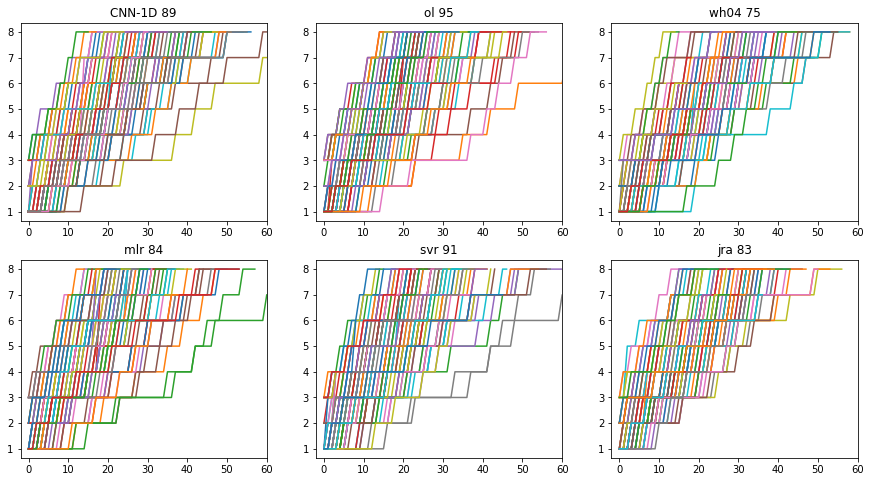

In [8]:
k1=0;k2=0;k3=0;k4=0;k5=0;k6=0
fig,ax = plt.subplots(2,3,figsize=(15,8))

for i in np.arange(36):
    aa_w =  events_wh04[i]
    aa_o =  events_ol[i]
    aa_c =  events_conv[i]
    aa_m =  events_mlr[i]
    aa_s =  events_svr[i]
    aa_j =  events_jra[i]
    
    
    for i in range(len(aa_c)):
        ax[0,0].plot(aa_c[i])
        k1=k1+1
        ax[0,0].set_title('CNN-1D %d' %k1)
        ax[0,0].set_xlim([-2,60])
    for i in range(len(aa_o)):
        ax[0,1].plot(aa_o[i])
        k2=k2+1
        ax[0,1].set_title('ol %d'%k2)
        ax[0,1].set_xlim([-2,60 ])

    for i in range(len(aa_w)):
        ax[0,2].plot(aa_w[i])
        k3=k3+1
        ax[0,2].set_title('wh04 %d' %k3)
        ax[0,2].set_xlim([-2,60 ])

    for i in range(len(aa_m)):
        ax[1,0].plot(aa_m[i])
        k4=k4+1
        ax[1,0].set_title('mlr %d' %k4)
        ax[1,0].set_xlim([-2,60 ])

    for i in range(len(aa_s)):
        ax[1,1].plot(aa_s[i])
        k5=k5+1
        ax[1,1].set_title('svr %d' %k5)
        ax[1,1].set_xlim([-2,60 ])

    for i in range(len(aa_j)):
        ax[1,2].plot(aa_j[i])
        k6=k6+1
        ax[1,2].set_title('jra %d' %k6)
        ax[1,2].set_xlim([-2,60 ])

print(k1,k2,k3,k4,k5,k6)

In [9]:
# n1=1979;AA= AA1_wh04;PP=phase1_wh04_filt
# AA.loc[str(n1)+'-11-01':str(n1+1)+'-04-30'].values,PP.loc[str(n1)+'-11-01':str(n1+1)+'-04-30'].values,events_wh04[0]

## Number events

12 12


(0.5657003807387129, 0.4691993341493339, 0.602436111862074)

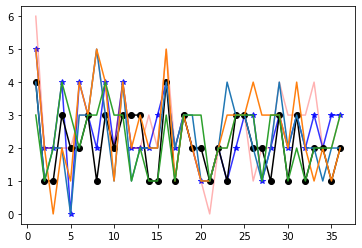

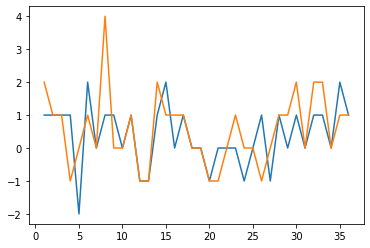

In [10]:
tt =np.arange(1,37,1)
plt.plot(tt,no_events_conv, '-*b',alpha=0.8)
plt.plot(tt,no_events_ol,color= 'r',alpha=0.3)
plt.plot(tt,no_events_wh04,'-ok')
plt.plot(tt,no_events_mlr)
plt.plot(tt,no_events_svr)
plt.plot(tt,no_events_jra)


aa=no_events_conv-no_events_wh04
bb=no_events_ol-no_events_wh04
plt.figure()
plt.plot(tt,aa)
plt.plot(tt,bb)
print(len(np.where(aa==0)[0]),len(np.where(bb==0)[0]))
np.corrcoef(no_events_conv,no_events_wh04)[0,1],np.corrcoef(no_events_ol,no_events_wh04)[0,1],np.corrcoef(no_events_ol,no_events_conv)[0,1]


,0,1,2,3,4,5
0,1.000000,0.602436,0.565700,0.563473,0.552367,0.406205
1,0.602436,1.000000,0.469199,0.723026,0.626401,0.289978
2,0.565700,0.469199,1.000000,0.353423,0.535571,0.565873
3,0.563473,0.723026,0.353423,1.000000,0.732341,0.396908
4,0.552367,0.626401,0.535571,0.732341,1.000000,0.369762
5,0.406205,0.289978,0.565873,0.396908,0.369762,1.000000


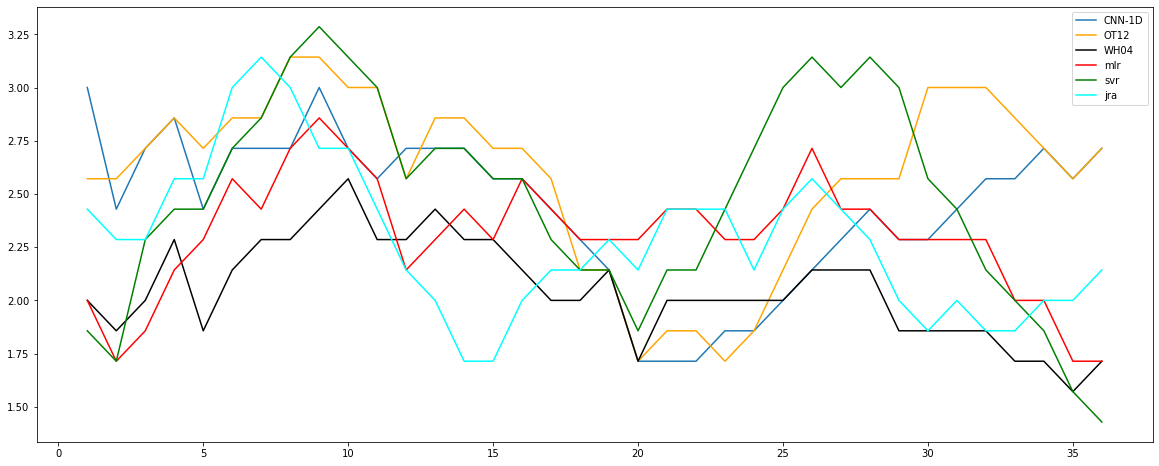

In [11]:
plt.figure(figsize=(20,8))
cc_conv = smooth(no_events_conv,window_len=7,window='flat')[3:-3]
plt.plot(tt,cc_conv,color='C0',label='CNN-1D')

cc_ol = smooth(no_events_ol,window_len=7,window='flat')[3:-3]
plt.plot(tt,cc_ol,color='orange',label='OT12')

cc_wh04 = smooth(no_events_wh04,window_len=7,window='flat')[3:-3]
plt.plot(tt[-36:],cc_wh04,color='k',label='WH04')

cc_mlr = smooth(no_events_mlr,window_len=7,window='flat')[3:-3]
plt.plot(tt[-36:],cc_mlr,color='r',label='mlr')

cc_svr = smooth(no_events_svr,window_len=7,window='flat')[3:-3]
plt.plot(tt[-36:],cc_svr,color='g',label='svr')

cc_jra = smooth(no_events_jra,window_len=7,window='flat')[3:-3]
plt.plot(tt[-36:],cc_jra,color='cyan',label='jra')

plt.legend()

AA = pd.DataFrame(np.array([no_events_conv,no_events_ol,no_events_wh04,no_events_mlr,no_events_svr,no_events_jra]).T)

AA.corr()
# np.corrcoef(cc_wh04,cc_conv)[0,1],np.corrcoef(cc_wh04,cc_ol)[0,1],np.corrcoef(cc_ol,cc_conv)[0,1]
# # plt.plot(np.arange(1,110,1),lf_567_ol,alpha=0.8)

## phase 567 duration

nan nan
nan nan
0.06505178648035785 7.52484182561682e-06


(nan, nan, nan)

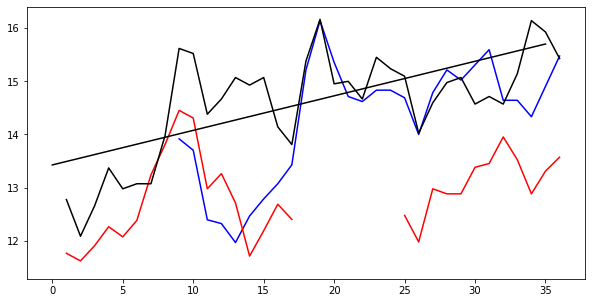

In [12]:
cs_conv = smooth(lf_567_conv,window_len=7,window='flat')[3:-3]
cs_ol = smooth(lf_567_ol,window_len=7,window='flat')[3:-3]
cs_wh04 = smooth(lf_567_wh04,window_len=7,window='flat')[3:-3]

# cs_conv = lf_567_conv*1
# cs_ol = lf_567_ol*1
# cs_wh04 = lf_567_wh04*1

tt =np.arange(1,37,1)

plt.figure(figsize=(10,5))
plt.plot(tt,cs_conv[-36:],'-b')
slope_cs,int_cs,_,p_c,_ = stats.linregress(tt,cs_conv[-36:] )
plt.plot(tt*slope_cs+int_cs,'b')
print(slope_cs,p_c)

plt.plot(tt,cs_ol[-36:],'-r')
slope_cs,int_cs,_,p_c,_ = stats.linregress(tt,cs_ol[-36:] )
plt.plot(tt*slope_cs+int_cs,'r')
print(slope_cs,p_c)

plt.plot(tt,cs_wh04,'-k')
slope_cs,int_cs,_,p_c,_ = stats.linregress(tt,cs_wh04 )
plt.plot(tt*slope_cs+int_cs,'k')
print(slope_cs,p_c)

np.corrcoef(cs_conv,cs_wh04)[0,1],np.corrcoef(cs_ol,cs_wh04)[0,1],np.corrcoef(cs_conv,cs_ol)[0,1]
# plt.scatter(lf_567_ol[-36:],lf_567_wh04)

## Full period

/home/cccr/supriyo/.conda/envs/environment1/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


(2.210698342561529, 4.070364226398992e-28)

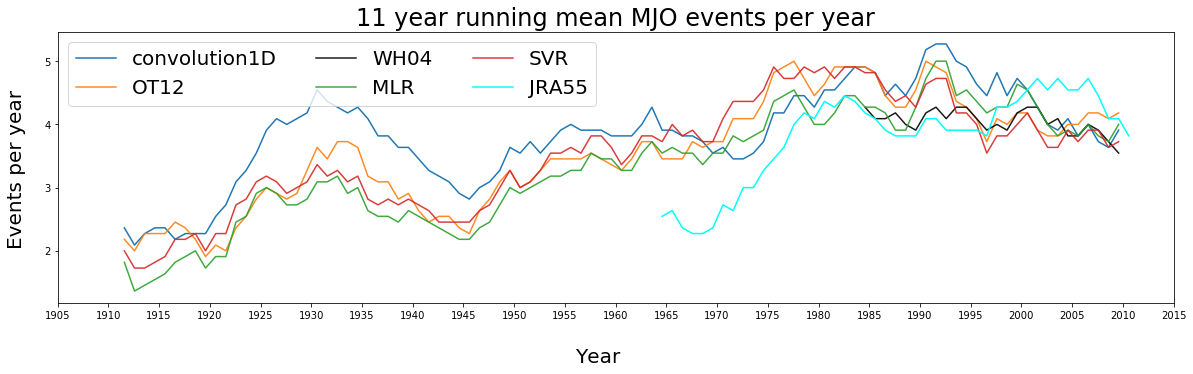

In [13]:
window_len=11 ; ww = 2*(window_len//2)
yy=str(int(1906+ww/2));ll1= 109-ww;yy2=str(int(1979+ww/2));ll2=36-ww;yy3=str(int(1959+ww/2));ll3=57-ww


season = 'allyear'
no_events_conv,events_conv,life_conv,lf_123_conv,lf_567_conv = mjo_events(AA1_conv,phase1_conv_hist,1906,109,season)
no_events_ol,events_ol,life_ol,lf_123_ol,lf_567_ol = mjo_events(AA1_ol,phase1_ol_hist,1906,109,season)
no_events_wh04,events_wh04,life_wh04,lf_123_wh04,lf_567_wh04 = mjo_events(AA1_wh04,phase1_wh04_filt,1979,36,season)
no_events_mlr,events_mlr,life_mlr,lf_123_mlr,lf_567_mlr = mjo_events(AA1_mlr,phase1_mlr_hist,1906,109,season)
no_events_svr,events_svr,life_svr,lf_123_svr,lf_567_svr = mjo_events(AA1_svr,phase1_svr_hist,1906,109,season)
no_events_jra,events_jra,life_jra,lf_123_jra,lf_567_jra = mjo_events(AA1_jra,phase1_jra_hist,1959,57,season)

cc_conv = smooth(no_events_conv,window_len=window_len,window='flat')[ww:-ww]

cc_ol = smooth(no_events_ol,window_len=window_len,window='flat')[ww:-ww]

cc_wh04 = smooth(no_events_wh04,window_len=window_len,window='flat')[ww:-ww]

cc_mlr = smooth(no_events_mlr,window_len=window_len,window='flat')[ww:-ww]

cc_svr = smooth(no_events_svr,window_len=window_len,window='flat')[ww:-ww]

cc_jra = smooth(no_events_jra,window_len=window_len,window='flat')[ww:-ww]


df_conv_3yr  =   pd.DataFrame(cc_conv,index=pd.date_range(yy+'-01-01',periods=ll1,freq='Y'),columns=['duration'])
df_ol_3yr    =   pd.DataFrame(cc_ol,index=pd.date_range(yy+'-01-01',periods=ll1,freq='Y'),columns=['duration'])
df_wh04_3yr  =   pd.DataFrame(cc_wh04,index=pd.date_range(yy2+'-01-01',periods=ll2,freq='Y'),columns=['duration'])
df_mlr_3yr   =   pd.DataFrame(cc_mlr,index=pd.date_range(yy+'-01-01',periods=ll1,freq='Y'),columns=['duration'])
df_svr_3yr   =   pd.DataFrame(cc_svr,index=pd.date_range(yy+'-01-01',periods=ll1,freq='Y'),columns=['duration'])
df_jra_3yr   =   pd.DataFrame(cc_jra,index=pd.date_range(yy3+'-01-01',periods=ll3,freq='Y'),columns=['duration'])

df_events_all_3yr=pd.concat([df_conv_3yr,df_ol_3yr,df_wh04_3yr,df_mlr_3yr,df_svr_3yr,df_jra_3yr],axis=1)


import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import host_subplot

fig,ax=plt.subplots(1,1,figsize=(20,5))

plt.rcParams['font.weight'] = 'normal'
plt.rcParams['font.size'] = 20
plt.rcParams['image.cmap'] = 'seismic'


ax.plot(df_events_all_3yr.iloc[:,0],label='convolution1D')
ax.plot(df_events_all_3yr.iloc[:,1],'-',label='OT12',alpha=0.9)
ax.plot(df_events_all_3yr.iloc[:,2],'k',label='WH04',alpha=0.9)
ax.plot(df_events_all_3yr.iloc[:,3],'-',label='MLR',alpha=0.9)
ax.plot(df_events_all_3yr.iloc[:,4],'-',label='SVR',alpha=0.9)
# ax.plot(df_events_all_3yr.iloc[:,5]-df_events_all_3yr.iloc[:,5].mean(),'-.',label='C2D',alpha=0.5,color='magenta')
ax.plot(df_events_all_3yr.iloc[:,5],'-',label='JRA55',color='cyan')





ax.set_xlim([datetime.datetime(1905,6,1),datetime.datetime(2015,6,1)])


fig.text(0.5, -0.04, 'Year', ha='center')
fig.text(0.09, 0.5, 'Events per year', va='center', rotation='vertical')
# ax.axvspan(datetime.datetime(1921,6,1),datetime.datetime(1945,6,1),color = 'r',alpha = 0.05)
# ax.axvspan(datetime.datetime(1945,6,1),datetime.datetime(1978,6,1),color = 'b',alpha = 0.05)
# ax.axvspan(datetime.datetime(1978,6,1),datetime.datetime(2004,6,1),color = 'r',alpha = 0.05)# ax.axvspan(1998,2012,alpha = 0.1)
# ax.axvspan(datetime.datetime(2004,6,1),datetime.datetime(2012,6,1),color = 'b',alpha = 0.05)

plt.legend(ncol=3)
plt.title('11 year running mean MJO events per year')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=60))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
# plt.gcf().autofmt_xdate() # Rotation
fig.savefig('/home/cccr/supriyo/panini/jgrjd_figure8a.png',dpi=1200,bbox_inches='tight')


def trend_events():
    
    temp =df_events_all_3yr.mean(axis=1).values.squeeze()[0:]
    res,c,_,p,_  = stats.linregress(np.arange(1,len(temp)+1),temp)
    plt.plot(temp)
    plt.plot(res*np.arange(1,len(temp)+1)+c)
    return res*100,p
trend_events()

(1.0469174190146284, 3.2176325419515327e-19)

<Figure size 1440x576 with 0 Axes>

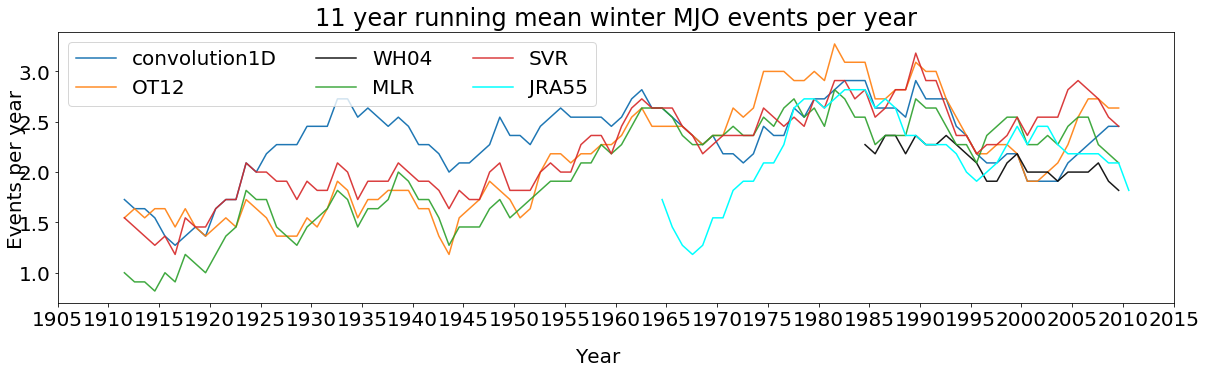

In [14]:
window_len=11 ; ww = 2*(window_len//2)
yy=str(int(1906+ww/2));ll1= 109-ww;yy2=str(int(1979+ww/2));ll2=36-ww;yy3=str(int(1959+ww/2));ll3=57-ww


season = 'winter'
no_events_conv,events_conv,life_conv,lf_123_conv,lf_567_conv = mjo_events(AA1_conv,phase1_conv_hist,1906,109,season)
no_events_ol,events_ol,life_ol,lf_123_ol,lf_567_ol = mjo_events(AA1_ol,phase1_ol_hist,1906,109,season)
no_events_wh04,events_wh04,life_wh04,lf_123_wh04,lf_567_wh04 = mjo_events(AA1_wh04,phase1_wh04_filt,1979,36,season)
no_events_mlr,events_mlr,life_mlr,lf_123_mlr,lf_567_mlr = mjo_events(AA1_mlr,phase1_mlr_hist,1906,109,season)
no_events_svr,events_svr,life_svr,lf_123_svr,lf_567_svr = mjo_events(AA1_svr,phase1_svr_hist,1906,109,season)
no_events_jra,events_jra,life_jra,lf_123_jra,lf_567_jra = mjo_events(AA1_jra,phase1_jra_hist,1959,57,season)

plt.figure(figsize=(20,8))
cc_conv = smooth(no_events_conv,window_len=window_len,window='flat')[ww:-ww]

cc_ol = smooth(no_events_ol,window_len=window_len,window='flat')[ww:-ww]

cc_wh04 = smooth(no_events_wh04,window_len=window_len,window='flat')[ww:-ww]

cc_mlr = smooth(no_events_mlr,window_len=window_len,window='flat')[ww:-ww]

cc_svr = smooth(no_events_svr,window_len=window_len,window='flat')[ww:-ww]

cc_jra = smooth(no_events_jra,window_len=window_len,window='flat')[ww:-ww]


df_conv_3yr  =   pd.DataFrame(cc_conv,index=pd.date_range(yy+'-01-01',periods=ll1,freq='Y'),columns=['duration'])
df_ol_3yr    =   pd.DataFrame(cc_ol,index=pd.date_range(yy+'-01-01',periods=ll1,freq='Y'),columns=['duration'])
df_wh04_3yr  =   pd.DataFrame(cc_wh04,index=pd.date_range(yy2+'-01-01',periods=ll2,freq='Y'),columns=['duration'])
df_mlr_3yr   =   pd.DataFrame(cc_mlr,index=pd.date_range(yy+'-01-01',periods=ll1,freq='Y'),columns=['duration'])
df_svr_3yr   =   pd.DataFrame(cc_svr,index=pd.date_range(yy+'-01-01',periods=ll1,freq='Y'),columns=['duration'])
df_jra_3yr   =   pd.DataFrame(cc_jra,index=pd.date_range(yy3+'-01-01',periods=ll3,freq='Y'),columns=['duration'])

df_events_all_3yr=pd.concat([df_conv_3yr,df_ol_3yr,df_wh04_3yr,df_mlr_3yr,df_svr_3yr,df_jra_3yr],axis=1)

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import host_subplot

fig,ax=plt.subplots(1,1,figsize=(20,5))

plt.rcParams['font.weight'] = 'normal'
plt.rcParams['font.size'] = 20
plt.rcParams['image.cmap'] = 'seismic'


ax.plot(df_events_all_3yr.iloc[:,0],label='convolution1D')
ax.plot(df_events_all_3yr.iloc[:,1],'-',label='OT12',alpha=0.9)
ax.plot(df_events_all_3yr.iloc[:,2],'k',label='WH04',alpha=0.9)
ax.plot(df_events_all_3yr.iloc[:,3],'-',label='MLR',alpha=0.9)
ax.plot(df_events_all_3yr.iloc[:,4],'-',label='SVR',alpha=0.9)
# ax.plot(df_events_all_3yr.iloc[:,5]-df_events_all_3yr.iloc[:,5].mean(),'-.',label='C2D',alpha=0.5,color='magenta')
ax.plot(df_events_all_3yr.iloc[:,5],'-',label='JRA55',color='cyan')





ax.set_xlim([datetime.datetime(1905,6,1),datetime.datetime(2015,6,1)])


fig.text(0.5, -0.04, 'Year', ha='center')
fig.text(0.09, 0.5, 'Events per year', va='center', rotation='vertical')

plt.legend(ncol=3)
plt.title('11 year running mean winter MJO events per year')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=60))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
# plt.gcf().autofmt_xdate() # Rotation

fig.savefig('/home/cccr/supriyo/panini/jgrjd_figure8b.png',dpi=1200,bbox_inches='tight')

    
trend_events()


(1.039585776759494, 4.389106288919782e-21)

<Figure size 1440x576 with 0 Axes>

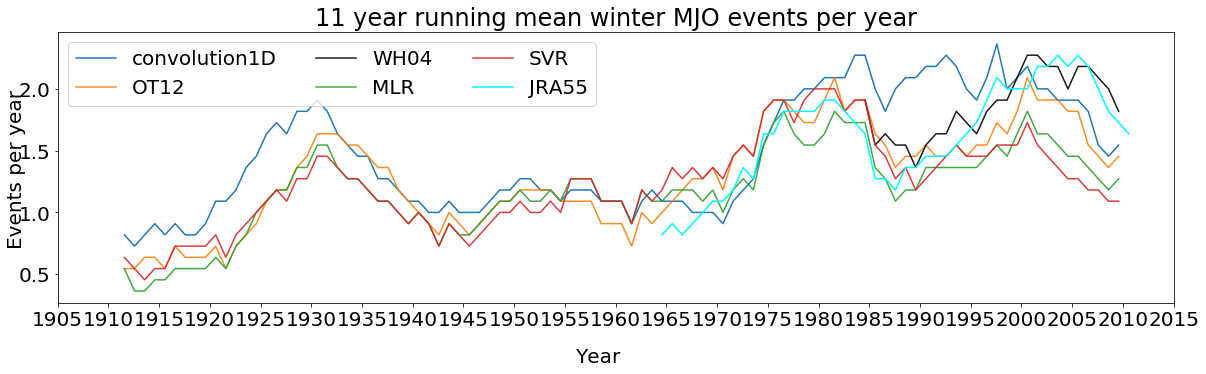

In [15]:
window_len=11 ; ww = 2*(window_len//2)
yy=str(int(1906+ww/2));ll1= 109-ww;yy2=str(int(1979+ww/2));ll2=36-ww;yy3=str(int(1959+ww/2));ll3=57-ww


season = 'summer'
no_events_conv,events_conv,life_conv,lf_123_conv,lf_567_conv = mjo_events(AA1_conv,phase1_conv_hist,1906,109,season)
no_events_ol,events_ol,life_ol,lf_123_ol,lf_567_ol = mjo_events(AA1_ol,phase1_ol_hist,1906,109,season)
no_events_wh04,events_wh04,life_wh04,lf_123_wh04,lf_567_wh04 = mjo_events(AA1_wh04,phase1_wh04_filt,1979,36,season)
no_events_mlr,events_mlr,life_mlr,lf_123_mlr,lf_567_mlr = mjo_events(AA1_mlr,phase1_mlr_hist,1906,109,season)
no_events_svr,events_svr,life_svr,lf_123_svr,lf_567_svr = mjo_events(AA1_svr,phase1_svr_hist,1906,109,season)
no_events_jra,events_jra,life_jra,lf_123_jra,lf_567_jra = mjo_events(AA1_jra,phase1_jra_hist,1959,57,season)

plt.figure(figsize=(20,8))
cc_conv = smooth(no_events_conv,window_len=window_len,window='flat')[ww:-ww]

cc_ol = smooth(no_events_ol,window_len=window_len,window='flat')[ww:-ww]

cc_wh04 = smooth(no_events_wh04,window_len=window_len,window='flat')[ww:-ww]

cc_mlr = smooth(no_events_mlr,window_len=window_len,window='flat')[ww:-ww]

cc_svr = smooth(no_events_svr,window_len=window_len,window='flat')[ww:-ww]

cc_jra = smooth(no_events_jra,window_len=window_len,window='flat')[ww:-ww]


df_conv_3yr  =   pd.DataFrame(cc_conv,index=pd.date_range(yy+'-01-01',periods=ll1,freq='Y'),columns=['duration'])
df_ol_3yr    =   pd.DataFrame(cc_ol,index=pd.date_range(yy+'-01-01',periods=ll1,freq='Y'),columns=['duration'])
df_wh04_3yr  =   pd.DataFrame(cc_wh04,index=pd.date_range(yy2+'-01-01',periods=ll2,freq='Y'),columns=['duration'])
df_mlr_3yr   =   pd.DataFrame(cc_mlr,index=pd.date_range(yy+'-01-01',periods=ll1,freq='Y'),columns=['duration'])
df_svr_3yr   =   pd.DataFrame(cc_svr,index=pd.date_range(yy+'-01-01',periods=ll1,freq='Y'),columns=['duration'])
df_jra_3yr   =   pd.DataFrame(cc_jra,index=pd.date_range(yy3+'-01-01',periods=ll3,freq='Y'),columns=['duration'])

df_events_all_3yr=pd.concat([df_conv_3yr,df_ol_3yr,df_wh04_3yr,df_mlr_3yr,df_svr_3yr,df_jra_3yr],axis=1)

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import host_subplot

fig,ax=plt.subplots(1,1,figsize=(20,5))

plt.rcParams['font.weight'] = 'normal'
plt.rcParams['font.size'] = 20
plt.rcParams['image.cmap'] = 'seismic'


ax.plot(df_events_all_3yr.iloc[:,0],label='convolution1D')
ax.plot(df_events_all_3yr.iloc[:,1],'-',label='OT12',alpha=0.9)
ax.plot(df_events_all_3yr.iloc[:,2],'k',label='WH04',alpha=0.9)
ax.plot(df_events_all_3yr.iloc[:,3],'-',label='MLR',alpha=0.9)
ax.plot(df_events_all_3yr.iloc[:,4],'-',label='SVR',alpha=0.9)
# ax.plot(df_events_all_3yr.iloc[:,5]-df_events_all_3yr.iloc[:,5].mean(),'-.',label='C2D',alpha=0.5,color='magenta')
ax.plot(df_events_all_3yr.iloc[:,5],'-',label='JRA55',color='cyan')





ax.set_xlim([datetime.datetime(1905,6,1),datetime.datetime(2015,6,1)])


fig.text(0.5, -0.04, 'Year', ha='center')
fig.text(0.09, 0.5, 'Events per year', va='center', rotation='vertical')
plt.legend(ncol=3)
plt.title('11 year running mean winter MJO events per year')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=60))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
# plt.gcf().autofmt_xdate() # Rotation

trend_events()


